# Ciencia de Datos. TP6: Procesamiento de Lenguaje Natural

Axel Maddonni, LU 200/14 <br>
Federico Patane, LU 683/10<br>


*Diciembre 2017*

***

## Ejercicio 1: Asociación de Palabras

### 1. Lectura del Corpus

Para leer el corpus ap primero modificamos el archivo .txt para poder ser parseado como un .xml. Para eso, agregamos una etiqueta raíz (todo xml debe tener una), con el nombre "CORPUS" al principio y al final del archivo y lo guardamos con el nombre "ap.xml". Luego, utilizamos la librería "minidom" para parsear el xml resultante y extraer los textos de los documentos como pide el enunciado.

In [1]:
# Imports e inicializacion de variables globales para nltk
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer

sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
wordnet_lemmatizer = WordNetLemmatizer()
tokenizer = TreebankWordTokenizer()

In [7]:
# Creacion del xml
file_in = open("ap/ap.txt", "r")
txt = file_in.read()
file_in.close()

xml = "<CORPUS>" + txt + "</CORPUS>"
xml = xml.replace('&','&amp;')

file_out = open("ap/ap.xml", "w")
file_out.write(xml)
file_out.close()

In [8]:
# Parseo del xml
from xml.dom import minidom
xmldoc = minidom.parse('ap/ap.xml')
doclist = xmldoc.getElementsByTagName('DOC')

docs = {}
corpus_text = ''

for doc in doclist:
    docno = doc.getElementsByTagName('DOCNO')[0].firstChild.data.strip()
    text = doc.getElementsByTagName('TEXT')[0].firstChild.data.strip()
    docs[docno] = text
    corpus_text += text

### 2. Procesamiento y Armado del Vocabulario

#### Código para la clasificación de palabras usando tags de WordNet

In [4]:
from nltk.corpus import wordnet as wn

def is_noun(tag):
    return tag in ['NN', 'NNS', 'NNP', 'NNPS']

def is_verb(tag):
    return tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']

def is_adverb(tag):
    return tag in ['RB', 'RBR', 'RBS']

def is_adjective(tag):
    return tag in ['JJ', 'JJR', 'JJS']

def penn_to_wn(tag):
    if is_adjective(tag):
        return wn.ADJ
    elif is_noun(tag):
        return wn.NOUN
    elif is_adverb(tag):
        return wn.ADV
    elif is_verb(tag):
        return wn.VERB
    return None

#### Código para expansión de contracciones de palabras

In [5]:
import re

cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

caseInsCList = {}

for key, value in cList.items():
    caseInsCList[key.lower()] = value

c_re = re.compile('(%s)' % '|'.join(caseInsCList.keys()), re.IGNORECASE)

def expandContractions(text, c_re=c_re):
    def replace(match):
        return caseInsCList[match.group(0).lower()]
    return c_re.sub(replace, text)

#### Pasos para el procesamiento y armado del Vocabulario

1. Separación en sentencias
2. Expansión de contracciones
3. Tokenización
4. Pos-tagging
5. Uso del pos-tagging para lematizar
6. Eliminación de Stop-words

Para los puntos 1, 3, 4, 5 y 6 utilizamos funciones provistas por nltk, como se puede ver en el siguiente código:

In [26]:
def lemmatize_with_tag(word, tag):
    wordType = penn_to_wn(tag)
    if wordType is None:
        return None
    return wordnet_lemmatizer.lemmatize(word, pos=wordType)

vocabulary = {}
corpus_processed_tokens = []
positions = {}

pos = 0

for docno, text in docs.items():
    # 1
    sents = sent_detector.tokenize(text)
    for sent in sents:
        # 2
        sent = expandContractions(sent)
        # 3
        tokens = tokenizer.tokenize(sent)
        # 4
        token_with_tags = nltk.pos_tag(tokens)
        for token_with_tag in token_with_tags:
            # 5
            word = lemmatize_with_tag(token_with_tag[0], token_with_tag[1])
            # 6
            if word is not None and word not in stopwords.words('english') and word.isalpha():
                corpus_processed_tokens.append(word)
                if word in vocabulary:
                    vocabulary[word] += 1
                    positions[word].append(pos)
                else:
                    vocabulary[word] = 1
                    positions[word] = [pos]
                pos += 1

#### Tamaño del Vocabulario final

In [7]:
print(len(vocabulary))

37118


### 3. Pares más asociados

Primero, mostramos cuáles son las 500 palabras con más apariciones en el vocabulario:

In [8]:
import operator
sorted_vocabulary = sorted(vocabulary.items(), key=operator.itemgetter(1))
the500 = list(map(lambda x: x[0], sorted_vocabulary[-500:]))[::-1]

In [9]:
# Las 500 palabras con más apariciones, de mayor a menor
the500

[u'say',
 u'year',
 u'percent',
 u'people',
 u'also',
 u'government',
 u'make',
 u'U.S.',
 u'official',
 u'report',
 u'last',
 u'go',
 u'take',
 u'_',
 u'state',
 u'time',
 u'Bush',
 u'include',
 u'new',
 u'get',
 u'day',
 u'first',
 u'Soviet',
 u'tell',
 u'week',
 u'New',
 u'United',
 u'company',
 u'use',
 u'call',
 u'work',
 u'month',
 u'country',
 u'give',
 u'come',
 u'today',
 u'plan',
 u'president',
 u'police',
 u'Thursday',
 u'American',
 u'group',
 u'States',
 u'Tuesday',
 u'market',
 u'member',
 u'price',
 u'President',
 u'issue',
 u'Monday',
 u'high',
 u'Friday',
 u'force',
 u'Wednesday',
 u'know',
 u'think',
 u'want',
 u'find',
 u'begin',
 u'charge',
 u'leader',
 u'home',
 u'end',
 u'York',
 u'leave',
 u'show',
 u'hold',
 u'case',
 u'program',
 u'kill',
 u'good',
 u'help',
 u'military',
 u'support',
 u'increase',
 u'nation',
 u'House',
 u'right',
 u'see',
 u'federal',
 u'late',
 u'order',
 u'many',
 u'vote',
 u'talk',
 u'city',
 u'ask',
 u'rate',
 u'expect',
 u'part',
 u'poli

Para calcular los pares más asociados primero probamos la herramienta de nltk BigramCollocationFinder, que permite encontrar y rankear colocaciones (palabras que suelen aparecer juntas), utilizando un tamaño de ventana de tamaño 5, como se menciona en el paper correspondiente a este ejercicio.

El resultado nos dejó algo desconcertados ya que no podíamos ver a simple vista una relación muy estrecha entre los pares que obtuvimos, de modo que decidimos implementar "información mutua", con la fórmula como se la explica en el paper para chequear los resultados.

Para este ejercicio, utilizamos los tokens del corpus luego de ser procesado, ya que estamos buscando pares que contengan las 500 palabras con más frecuencia en el vocabulario, que se obtuvieron después del procesamiento del texto.

In [ ]:
# Pares usando BigramCollocationFinder

from nltk.collocations import BigramCollocationFinder
bigram_measures = nltk.collocations.BigramAssocMeasures()

def getBestPairContaining(word, tokens):
    finder = BigramCollocationFinder.from_words(tokens, window_size = 5)
    finder.apply_ngram_filter(lambda w1, w2: word not in (w1, w2))
    return finder.nbest(bigram_measures.pmi, 1)[0]

In [14]:
pairs = []
for word in the500:
    pairs.append(getBestPairContaining(word, corpus_processed_tokens))

for i in range(0, len(the500)):
    print("Rank %d. Word: %s" % (i+1, the500[i]) )
    print("Best pair: ", pairs[i])

Rank 1. Word: say
('Best pair: ', (u'Baruch', u'say'))
Rank 2. Word: year
('Best pair: ', (u'737-series', u'year'))
Rank 3. Word: percent
('Best pair: ', (u'-Florida', u'percent'))
Rank 4. Word: people
('Best pair: ', (u'people', u'shady'))
Rank 5. Word: also
('Best pair: ', (u'Carbonell', u'also'))
Rank 6. Word: government
('Best pair: ', (u'13-month', u'government'))
Rank 7. Word: make
('Best pair: ', (u"'80s", u'make'))
Rank 8. Word: U.S.
('Best pair: ', (u'U.S.', u'Kimba'))
Rank 9. Word: official
('Best pair: ', (u'-U.S.', u'official'))
Rank 10. Word: report
('Best pair: ', (u'-Kmart', u'report'))
Rank 11. Word: last
('Best pair: ', (u'.5', u'last'))
Rank 12. Word: go
('Best pair: ', (u'go', u'glider'))
Rank 13. Word: take
('Best pair: ', (u'anyplace', u'take'))
Rank 14. Word: _
('Best pair: ', (u'CCCP', u'_'))
Rank 15. Word: state
('Best pair: ', (u'Assam', u'state'))
Rank 16. Word: time
('Best pair: ', (u'elapse', u'time'))
Rank 17. Word: Bush
('Best pair: ', (u'Bush', u'Bonesman

In [55]:
# Pares calculados a mano, siguiendo la explicación del paper

def most_associated_pairs(corpus_processed_tokens, vocabulary, positions, word1, window_size = None):
    if window_size is None:
        window_size = 5

    joint_probability_after = {}
    joint_probability_before = {}

    for p in positions[word1]:
        for i in range(0, window_size):
            
            if p+i+1 < len(corpus_processed_tokens):
                word2 = corpus_processed_tokens[p+i+1]
                if word2 in joint_probability_after:
                    joint_probability_after[word2] += 1
                else:
                    joint_probability_after[word2] = 1

            if p-i-1 >= 0:
                word2 = corpus_processed_tokens[p-i-1]
                if word2 in joint_probability_before:
                    joint_probability_before[word2] += 1
                else:
                    joint_probability_before[word2] = 1

    max_mutual_info = 0
    max_mutual_info_words = []

    N = len(corpus_processed_tokens)
    
    for word2 in joint_probability_after:
        mutual_info = np.log2( (joint_probability_after[word2] / N) /
                              (( vocabulary[word1] / N ) * ( vocabulary[word2] / N )) )
        if mutual_info > max_mutual_info:
            max_mutual_info = mutual_info
            max_mutual_info_words = [word2]
        elif mutual_info == max_mutual_info:
            max_mutual_info_words.append(word2)
    
    for word2 in joint_probability_before:
        mutual_info = np.log2( (joint_probability_before[word2] / N) /
                              (( vocabulary[word1] / N ) * ( vocabulary[word2] / N )) )
        if mutual_info > max_mutual_info:
            max_mutual_info = mutual_info
            max_mutual_info_words = [word2]
        elif mutual_info == max_mutual_info:
            max_mutual_info_words.append(word2)

    return max_mutual_info, max_mutual_info_words

In [75]:
rank = 1

real_associations = []

for word in the500:
    max_mutual_info, most_associated_words = most_associated_pairs(corpus_processed_tokens, vocabulary, positions, word, window_size=5)
    print("Rank %d. Word: %s" % (rank, word))
    print("Máximo valor de información mutua: %d" % max_mutual_info)
    print("Palabras más asociadas: " + str(', '.join(most_associated_words)))
    
    if len(most_associated_words) == 1:
        real_associations.append((max_mutual_info, word, most_associated_words[0]))

    rank += 1

Rank 1. Word: say
Máximo valor de información mutua: 6
Palabras más asociadas: government-paid, `A, almighty, approximately80, Brazilians, Espero, debriefing, Chianelli, Shimoyama, Bakir, hello, `Here, Uniformed, Kjell, deacon, writeoff, Quillen, `Daddy, Logar, 12-gauge, parry, Josephine, immobile, underfunded, soon-to-be-released, out-patient, fence-straddler, half-mile-wide, predate, overcarried, `Take, informative, 75-foot, government-sponsored, shorn, gleefully, Counseling, Philo, squealer, Cheltenham, Jackle, entrust, Participation, Ms, bravery, `Play, believeable, severest, MacMillin, mugging, tracer, winegrapes, doer, groundwater-protection, Fairield, enlightened, race-mixing, Democratic-oriented, `Anything, compromiser, Hans-Ludwig, hidebound, Studio, sump, domed, Butts, Scared, poached, dealer-owned, interplay, McCort, Co-chairman, vibrancy, Baruch, abrogate, observing, prepayment, Hawkes, `assault, candlewax, Grigg, squeak
Rank 2. Word: year
Máximo valor de información mutua:

Palabras más asociadas: Brautigan, pre-empted, trial-level, mantis, Lately, Assam, owes, sue4
Rank 16. Word: time
Máximo valor de información mutua: 9
Palabras más asociadas: elapse, telephoning
Rank 17. Word: Bush
Máximo valor de información mutua: 9
Palabras más asociadas: Bonesman, bantering
Rank 18. Word: include
Máximo valor de información mutua: 8
Palabras más asociadas: _Terminating, Ober, Shapira-Libai, semi-nude, fire-retardant-dropping, merganser, cactus, Fireman, Sin, Marche, Huallaga, mannerism, Downs, DiMaggio, 600,000-member, Crazy, Goodsprings, _Can, Wheel, campaign-finance, Jeep, Carnon, domed, lignite, USAir, destuuction, impressive-sounding, avocado, durum, sunflowerseed, Pioneering, Bellson, Yakety, raisin, Bridges, nine-point, dyskinesia, archconservative, crowbar, _Making, carbine, wasteful, goalie, Handicapped, Demographers, pre-release, sturgeon, Consciousness, immaculately, prizefighter, Chelyabinsk, metropolitan-area, coca-producing, Gupta, 30-April, bare-breas

Rank 29. Word: use
Máximo valor de información mutua: 10
Palabras más asociadas: peyote
Rank 30. Word: call
Máximo valor de información mutua: 10
Palabras más asociadas: Vengeance, attorney-client, privelege, Garton-Ash
Rank 31. Word: work
Máximo valor de información mutua: 10
Palabras más asociadas: evangelism, dificult, craftsman, underfed
Rank 32. Word: month
Máximo valor de información mutua: 10
Palabras más asociadas: Irreversible
Rank 33. Word: country
Máximo valor de información mutua: 10
Palabras más asociadas: pollution-choked
Rank 34. Word: give
Máximo valor de información mutua: 10
Palabras más asociadas: Sabbath
Rank 35. Word: come
Máximo valor de información mutua: 10
Palabras más asociadas: Audiences, tracer
Rank 36. Word: today
Máximo valor de información mutua: 9
Palabras más asociadas: anti-monarchist, Mikolaj, Cullin, Rebelde, complaining, stockyard, flag-bedecked, majestically, Frankfurt-bound, timeout, acknowleged, Kelli-Lee, 12-minute, foist, Daffy, Sabalan, stabbi

Palabras más asociadas: treading, established, homone, over-believed, Blechman, bullishness, Rohr, .34, realm, dimissed, peseta, anxiously, indecisive, sanitary, aspirin-free, S.K, bargain-hunter, meander, .09, SUnday, lower-risk, Transactions, .19, dollar-selling, slippesd, 37,000-point, Yasumichi, _Farmers, high-technology, buffet, Plunging, .63, Weligama, fitful, BankAmerica, _Negotiate, 500-point, heightened, .79, delayed, Satoh, Schering, narrowing, blood-soaked, bevy, Rarely, widely-anticipated, .41, pull-back, handheld, snowball, Cosmo, .51, illegals, American-Soviet, carbon-zinc, marked-down, ranchero, meanderings, Activity, mid-range, Gutenburg, Walkmans, awaited, yo-yo, adults, breather, Tighter, Picard, free-fall, 20-1, thir, Barclays, reeling, Scandinavia, bargain-basement, Gunship, Fran, unequivocal, figure-8, sultry, MCI, congressionally, budgetary, cynicism, self-serve, Chizuko, Bernstein, Bulk, high-value, astute, Steels, underprice, thievery, `camel, awry, bullishness,

Máximo valor de información mutua: 10
Palabras más asociadas: dirt-like, dressing
Rank 69. Word: program
Máximo valor de información mutua: 10
Palabras más asociadas: unifying, 20-20, affordable-housing
Rank 70. Word: kill
Máximo valor de información mutua: 10
Palabras más asociadas: humanely, Vila
Rank 71. Word: good
Máximo valor de información mutua: 10
Palabras más asociadas: Single-family, cross-membership
Rank 72. Word: help
Máximo valor de información mutua: 10
Palabras más asociadas: develoing
Rank 73. Word: military
Máximo valor de información mutua: 9
Palabras más asociadas: Communism, Islami, heading, Fayadiyeh, Karantina, workhorse, detachment, interrelationship, decortions, Moriyama, armor-plated, self-approved, Dzerzhinsky, Galeano, Occasional, born-again, peninsla, Sauble, hindered, Sotiris, B-1, Shaltiel, military-to-military, attache, theat, Tblisi, bags, sustainment, Sgts, Jomhuri, shuttle-sized, built-in, forcefully, military-backed, Pro-democracy, direct-dial, operat

Máximo valor de información mutua: 10
Palabras más asociadas: 8-6, causation
Rank 98. Word: pay
Máximo valor de información mutua: 9
Palabras más asociadas: Tashjian, flashy, bubbling, non-service-connected, receivables, defrauded, acoustic, uncollected, guild, ALTSM, beneficaries, pre-1980, drawback, entitled, gastronomic, 232-pound, past-due, variable, befriend, _Four-member, airfare, N.Y.-company, Altovise, pneumoconiosis, Leuthhold, Kienasts, self-denial, creditable, profit-making, highest-earning, loaner-vehicle, dark-colored, Taxpayers, Saks, Ordway, handsome, disbanding, annuity, escaping, burger, Old-Age, prepayment, checkoff, materially, top-earning, _Cutting, angiography, presides, CPD, Pierre-Auguste, Rubens, anyhow, Accordingly, Fith, five-figure, 1.5-liter, Finch, highay, DSTs, non-service-connected, Pivovary, 8-cent-per-gallon, sickening, FINANCE, unfulfilled, Creative, half-mad, artist-in-residence, souvenir, Irvington, petty, Utility, four-member, forfeiture, hunk, meta

Rank 129. Word: allow
Máximo valor de información mutua: 10
Palabras más asociadas: Boulter, self-production, Alekseyeva, revenue-raising, near-monopoly, `Reagan-Bush, Purser, contruction, 20-30, biowarfare, Elizaveta, cheaply, Account, Hoang, Winifred, utilitarian, peek, radar-dodging, non-citizens, visitation, passenger-carrying, three-dimensional, ailing, pillowcase, Socialism, brand-name, superhot, Caltrans, cabal, governorate, Sudanese, Wajda, celebratin, bloom, '84, tariff-free, disallow, monument-crowded, fed, 10-island, Bloodstains, penalty-free, time-released, plainly, site-specific, two-engine, 274-203, Karl-Heinz, retard, Court-appointed, scrimp, 8,000-acre, eight-night, misrepresentation, insurors, multi-state, refusing, farce, Presumably, childlike, Ghazi, utilitarian, Censorship, Baldy, Sundays, breadth, sergeant-at-arms, Brunson, Galesburg, ailing, stereoscopic, facilitating, stimulating, Additionaly, Akis, Xuezhi, Insane, then-5-year-old, DeKoven, Senate-approved, talk-

Rank 175. Word: job
Máximo valor de información mutua: 11
Palabras más asociadas: unskilled
Rank 176. Word: Mrs.
Máximo valor de información mutua: 10
Palabras más asociadas: red-and-orange, Royalties, Nob, divorcee, teal, ex-serviceman, Troiullot, military-popular, unfaithful, Hedrick, hand-in-hand, trembling, polycystic, housewifery, `Angel, Lina, concussion, Hemlock, 650-member, McGregor, Rouse, audence, dog-eared, everlasting, encumber, exclaim, Franksville, Trouillot, Giusto, assassinated, quake-stricken, hostess, DIF, astrologist, Bloomberg, unceremonious, defiantly, Restreeting, chaff, dashed, fervently, Mid-Straffordshire, Brong, puree, Youths, Britain-versus-the-rest, teal, self-indulgent, Deppish, cross-chat, one-seat, occupying, 440,005-, Plainville, Jian, stewardesses, Copies, `Boy, horizontal, hostess, Tessie, Moeketsi, Match, Viscount, serf, ascertain, housewifery, Meeses, Rosalee, herniated, on-the-job-training, blender, buzzer, Ordained, Bruges, Tunnel, 50,001-, exclaim

Máximo valor de información mutua: 10
Palabras más asociadas: Glauber, 28-year, British-inspired, Peronist, promissory, ambivalence, Pro-democracy, quos, sue4, bedeck, untouchable, 14.6-million, authoritanism, Legislator, Established, sancrosanct, Hoagland, Christos, Indpendence, attendands, D-Neb., Democatic, Dimond, libelous, insisted, hae, off-limits, disbarment, Carols, 5-2, leakproof, Rich, Prominent, untrustworthy, two-engine, flammability, 30-month-old, gung-ho, 17-day, wrestling, strong-arm, overpass, mineral-rich, 88-1480, 95-nation, Pro-democracy, fascist, theologian, Pilot, Legitimate, Teel, Japan-U.S., reshuffle, admits, millons, moribound, rforms, autocratic, 23-year, Adrion, Golfers, fest, unwritten, orthodox, diplomatically, patchwork, Fate, countersuit, Prosecutions, 10-island, Matched, Calvitt, Cambodians, topless, Satsop, _Approved
Rank 229. Word: power
Máximo valor de información mutua: 11
Palabras más asociadas: bedridden, complicates
Rank 230. Word: officer
Máximo 

Palabras más asociadas: vex, Tabloid, unquestionable, Titanic, Earmarks, make-or-break, Foreign-exchange, Tailored, Ratings, Investing, expenditures, Slagle, Muggers, democracy-building, pin-striped, small-corporation, '91, deficit-ridden, bilion, D-La., Band-Aid, worsening, Ridenour, vex, line-item, `Massachusetts, repetition, Likening, one-by-one, Pentagan, entertainment-kind, under-report, enlargement, faze
Rank 301. Word: estimate
Máximo valor de información mutua: 10
Palabras más asociadas: Ewen, four-pound, Tristan, drug-smuggling, Dysart, swayed, mid-1987, non-drug-using, Tournament, AIDs, Isolde, orginally, reckon, Acquired, flood-damaged, overshot, Immune, unincorporated, _Threw, larger-than-expected, OES, full-, 10-inch-high, waterborne, Chilean, 2-week-long, binge, Belcourt, durum, unscathed, Damage, Vase, Damages, anthropology, two-room, Jewels, Forming, Barran, chip-size, record-tying, miilion, ventilation, reasearch, proviso, non-monogamous, unoffical, Refunds, crew-shift

Máximo valor de información mutua: 12
Palabras más asociadas: `lights, price-support
Rank 376. Word: General
Máximo valor de información mutua: 11
Palabras más asociadas: Accopunting, Woerner, Thackery, published, Zimmerman, Reconciliation, all-but-declared, Rajneeshee, Militant, _Navy, Tariffs, Saab, Hartigan, trade-policing, X-cars, Prussia, Preate, LeRoy, Steelmakers, Accounting, AViiON, Berg, Butterworth, Rogelio, Dynamics, CF6-80C2, Months, Niederhaus, Borg-Warner, discounter, mid-range, Schaible, creed, TRW, Champions, underfunded, Acceptance, Strand, McNamee, Whistle, Bander, Bunkie, 96-nation, `Reagan-Bush, Surgeon, _C.M, Yelena, Stimpson, Zionists, configure, '84, Suits, Nordberg, Nofziger, 92-nation, Advocate, Sutter, Kyu-hah, country-by-country, Schauerte, soon-to-be-released, Consul, Anders, choosing, Postmaster, Noack, phenomenally, kilogram
Rank 377. Word: sentence
Máximo valor de información mutua: 11
Palabras más asociadas: Second-degree, Zvi, two-and-a-half, presentenc

Máximo valor de información mutua: 12
Palabras más asociadas: U.S.-funded, Barclays
Rank 463. Word: supply
Máximo valor de información mutua: 12
Palabras más asociadas: PROGRAMS, EMPLOYMENT
Rank 464. Word: reform
Máximo valor de información mutua: 11
Palabras más asociadas: Ruutel, non-customer-related, stabilization, Huk, Insisting, standardized, Krosno, Gavriil, Dejian, Granting, taxpayer-paid, simplifies, Convicted, expansionist, Thg, burden-sharing, Jiro, Kamijima, Kielce, long-banned, child-killer, developing, soft-money, 14,820-acre, pro-democratic, Komeito, willmake, westward-looking, Personally, Genuine, agrarian, tourism-dependent, procrastinate, Rawlings, civil-service, complicates, Heherson, moscow, proving, Band-Aid, once-unthinkable, self-financing, German-led, Successive, beginings, passionate, Personally
Rank 465. Word: loss
Máximo valor de información mutua: 11
Palabras más asociadas: debenture, Ear, Picard, jaundice, 27-10, front-wheel, slackened, new-crop, 10-month, t

In [73]:
# Pares con mayor información mutua entre los 500

real_associations_sorted = sorted(real_associations, key=operator.itemgetter(0))
real_associations_sorted[-5:][::-1]

[(12.449602187572822, u'list', u'most-wanted'),
 (12.433834871714504, u'department', u'Seventy-five'),
 (12.418238016663485, u'weapon', u'thermonuclear'),
 (12.402807976093881, u'hit', u'do-wop'),
 (12.364939790503437, u'lot', u'Dania')]

Con nuestro algoritmo, pudimos verificar que el resultado arrojado por la herramienta de nltk BigramCollocationFinder se encontraba dentro de los resultados que obtuvimos con nuestra implementación de información asociada, utilizando una ventana de tamaño 5. Sin embargo, en muchos casos, se obtiene más de una palabra con el mismo valor de información mutua (el máximo entre todas las posibles palabras), pero BigramCollocationFinder sólo devuelve una de ellas. Nuestro algoritmo nos permitió ver que la mayoría de las palabras del ranking tiene muchas palabras entre sus más asociadas, pero siempre corresponde a valores muy pequeños. Generalmente, se obtuvo que las palabras más asociadas aparecen 2 veces en una ventana de tamaño 5 junto con la palabra del ranking.

Sin embargo, al realizar un top5 entre los pares que obtuvimos, se pueden observar al menos 2 casos que tienen más sentido y las palabras del par guardan una relación semántica. Por ejemplo, el par con mayor información mutua es el par ("list", "most-wanted"), haciendo referencia a las listas de personas "buscadas" por la policía. Otro de los pares es el par ("weapon", "thermonuclear").

En conclusión, esta medida no permite analizar con profundidad la importancia de estas asociaciones, ya que la mayoría se debe a muy pocas apariciones en conjunto como para sacar una conclusión sobre la asociación de estas palabras.

## Ejercicio 2

#### 1. Procesamiento del Texto

Para procesar el texto lo convertimos a minúsculas y eliminamos signos de puntuación para tokenizar.

In [15]:
darwinFile = open('darwin.txt', 'r') 
darwinText = darwinFile.read()

In [16]:
import string

def get_tokens(text):
    lowers = text.lower()
    #remove the punctuation using the character deletion step of translate
    no_punctuation = lowers.translate(None, string.punctuation)
    tokens = nltk.word_tokenize(no_punctuation)
    return tokens

In [17]:
darwinTokens = get_tokens(darwinText)

#### 2. Autocorrelación de las palabras

Para realizar este cálculo se implementaron las fórmulas provistas en el paper correspondiente:

1. Fórmula (1) para la autocorrelación
2. Fórmula (A.1) para posiciones en el texto
3. Fórmula (A.2) para rate of ocurrence
4. Fórmula (A.3) para kernel gaussiano

Al igual que se muestra en el paper, calculamos la autocorrelación para las palabras: 'instinct', 'plants' y 'for', variando el tau entre 0 y 10.000.

In [25]:
import math
import matplotlib.pyplot as plt

def word_positions(word, text):
    res = []
    for i in range(0, len(text)):
        if (text[i] == word):
            res.append(i)
    return res

def gaussian(pos, sigma=50):
    return (math.exp(- (pos**2) / (2 * sigma**2) )) / (math.sqrt(2 * math.pi) * sigma)

def rate_of_ocurrence(word, text, pos, wordPositions):
    res = 0
    for posprima in wordPositions:
        res += gaussian(pos - posprima, sigma=50) # valor de sigma sacado del paper
    return res
    
def autocorrelation(word, text, tau, wordPositions):
    avgMult = 0
    avgPos = 0
    avgPosPlusTau = 0
    avgPosSquare = 0
    for pos in range(0, len(text)):
        pwt = rate_of_ocurrence(word, text, pos, wordPositions)
        pwtPlusTau = rate_of_ocurrence(word, text, pos+tau, wordPositions)

        avgMult += pwt * pwtPlusTau
        avgPos += pwt
        avgPosPlusTau += pwtPlusTau
        avgPosSquare += pwt ** 2

    avgMult = avgMult / len(text)
    avgPos = avgPos / len(text)
    avgPosPlusTau = avgPosPlusTau / len(text)
    avgPosSquare = avgPosSquare / len(text)

    return (avgMult - avgPos * avgPosPlusTau) / ( avgPosSquare - avgPos ** 2)

autocorr_by_word = {}
max_tau = 10000
step = 50 # para disminuir la complejidad

for word in ['plants', 'instinct', 'for']:
    autocorrelation_array = []
    wordPositions = word_positions(word, darwinTokens)

    for tau in range(0, max_tau, step):
        autocorrelation_array.append(autocorrelation('instinct', darwinTokens, tau, wordPositions))
        
    autocorr_by_word[word] = autocorrelation_array

KeyboardInterrupt: 

Gráficos de autocorrelación por palabra y conclusiones

#### 3. Entropía de las palabras

Para calcular la entropía se implementó la fórmula (3) del paper, y seleccionamos 100 palabras con frecuencias repartidas entre las distintas frecuencias de palabras en el texto. Para ello primero las ordenamos de mayor a menor frecuencia usando DistFreq de nltk.

Calculamos la entropía con el texto ordenado, y con el texto randomizado, y graficamos los resultados obtenidos en cada uno en un gráfico de puntos.

In [18]:
import numpy as np
from __future__ import division

def cuantas_apariciones_en_zona(zona, palabra):
    resultado = 0
    for z in zona : 
        if z == palabra : 
            resultado = resultado + 1
    return resultado

def entropia(tokens, palabras, cant_partes = None):

    if cant_partes is None:
        cant_partes = 64

    tamanio_partes = int(len(tokens) / cant_partes)
    capitulos = []
    for i in range(0, cant_partes):
        capitulos.append(tokens[i * tamanio_partes : i * tamanio_partes + tamanio_partes])
    
    frecuencias = []
    entropias = []

    for p in palabras : 
        n_grande = cuantas_apariciones_en_zona(tokens, p)
 
        sumatoria = 0
        for i in range(0,cant_partes):
            n_chica = cuantas_apariciones_en_zona(capitulos[i] , p)
            if not n_chica == 0 : 
                sumatoria = sumatoria + np.log2(n_chica / n_grande) * (n_chica / n_grande)

        frecuencias.append(n_grande)
        entropias.append(-1*sumatoria)

    return frecuencias , entropias

In [19]:
from nltk import FreqDist

frecuencias = FreqDist(darwinTokens)

tam_frecuencias = len(frecuencias)

frecuencias_ordenadas = frecuencias.most_common(tam_frecuencias)

palabras = []
for i in range (0, tam_frecuencias, int(tam_frecuencias / 1000)):
    palabras.append(frecuencias_ordenadas[i][0])
    if len(palabras) == 100:
        break

In [20]:
frecuencias, entropias = entropia(darwinTokens, palabras)

from random import shuffle
import copy

randomTokens = copy.deepcopy(darwinTokens)
shuffle(randomTokens)

frecuencias, entropias_random = entropia(randomTokens, palabras)

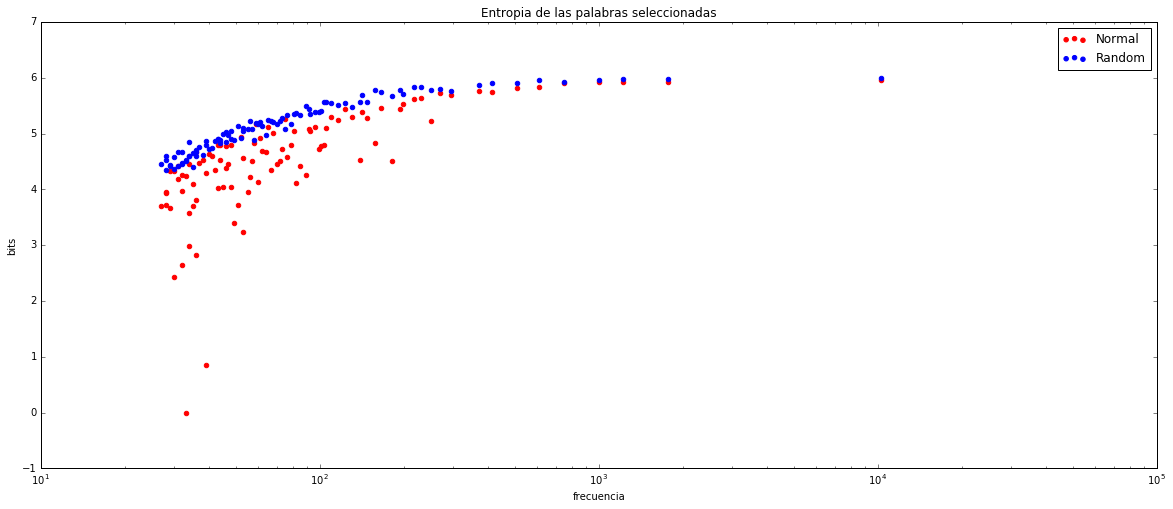

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,8))
plt.scatter(frecuencias, entropias , label = 'Normal', color = 'r')
plt.scatter(frecuencias, entropias_random , label = 'Random', color = 'b')
plt.legend(loc='best')
ax = plt.gca()
ax.set_xscale('log')
plt.title("Entropia de las palabras seleccionadas")
plt.xlabel("frecuencia")
plt.ylabel("bits")
plt.show()

Completar titulos y ejes de los graficos y conclusion de los mismos

## Ejercicio 3: Word embeddings

### LSA Representation

In [68]:
from gensim import corpora
from gensim.models import TfidfModel
from gensim.models import LsiModel
from gensim.similarities import MatrixSimilarity

import numpy as np
import math

def preprocess(text):
    text = text.lower()
    doc = nltk.word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()]
    return doc

def train_lsa_model(corpus, dims):
    dictionary = corpora.Dictionary(corpus)
    corpus_gensim = [dictionary.doc2bow(doc) for doc in corpus]
    tfidf = TfidfModel(corpus_gensim)
    corpus_tfidf = tfidf[corpus_gensim]
    lsi = LsiModel(corpus_tfidf, id2word=dictionary, num_topics=dims)
    return lsi, dictionary

def convert_to_lsi_space(lsiModel, dictionary, word):
    vec_bow = dictionary.doc2bow([word])
    return lsiModel[vec_bow]

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2' """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def lsa_similarity(v1, v2):
    v1 = list(map(lambda x: x[1], v1))
    v2 = list(map(lambda x: x[1], v2))
    return math.cos(angle_between(v1, v2))


In [66]:
lsa_corpus = []

for docno, text in docs.items():
    lsa_corpus.append(preprocess(text))
    
lsiModel, dictionary = train_lsa_model(lsa_corpus, 50)

In [91]:
# LSA Similarity

word1 = "tiger"
word2 = "cat"

if word1 in dictionary.values() and word2 in dictionary.values():
    v1 = convert_to_lsi_space(lsiModel, dictionary, word1)
    v2 = convert_to_lsi_space(lsiModel, dictionary, word2)
    print(lsa_similarity(v1, v2))
else:
    print("No se encuentran en el corpus")

0.151687677435


### Word2Vec Representation

### Comparación usando WordSim353

### Comparación usando WordNet Similarity

In [102]:
# Medidas de wordnet

from nltk.corpus import wordnet as wn

hit = wn.synset('hit.v.01')
slap = wn.synset('slap.v.01')

print(wn.path_similarity(hit, slap)) # range 0 to 1

# Leacock-Chodorow Similarity
print(wn.lch_similarity(hit, slap)) # -log(p/2d) where p is the shortest path length and d the taxonomy depth

# Wu-Palmer Similarity
print(wn.wup_similarity(hit, slap)) # range 0 to 1

0.142857142857
1.31218638897
0.25
